<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/dev%2Ffarrel/notebooks/vidi/train_sfcn_best_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SFCN Training Notebook
# Scale-aware Feature Pyramid Network for Crowd Counting

This notebook implements SFCN with VGG16-BN backbone for crowd counting tasks.

## Features:
- VGG16-BN backbone with spatial encoder
- Adaptive density map generation with KNN-based sigma
- Advanced data augmentation with patch-based training
- Mixed precision training with gradient accumulation
- Early stopping and model checkpointing
- Optional empty patch avoidance for better training

In [14]:
# Import Required Libraries and Setup
import os
import re
import json
import math
import random
import argparse
import warnings
from glob import glob
from typing import List, Tuple

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")

# Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA L4
CUDA memory: 23.8 GB


## Dataset Download and Setup

In [15]:
# @title Setup Kaggle secret key

"""
You don't need to run this cell if you're not in Google Colab environment
"""

!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [16]:
# @title Setup dataset in Colab

"""
You don't need to run this cell if you're not in Google Colab environment
"""

import zipfile
import os
from google.colab import drive

drive.mount('/content/drive')

# Paths
zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
drive_extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"
local_dataset_path = "/content/dataset"  # for current session

# ---------------------------
# Step 1: Download zip (if not exists in /content)
# ---------------------------
if not os.path.exists(zip_path):
    print("Dataset not found locally, downloading...")
    !kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining -p /content
else:
    print("Dataset already exists, skipping download.")

# ---------------------------
# Step 2: Extract to Google Drive (for backup)
# ---------------------------
os.makedirs(drive_extract_path, exist_ok=True)

if not os.listdir(drive_extract_path):  # Check if folder is empty
    print("Extracting dataset to Google Drive...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(drive_extract_path)
    print("Dataset extracted to:", drive_extract_path)
else:
    print("Dataset already extracted at:", drive_extract_path)

# ---------------------------
# Step 3: Copy dataset to local /content (faster training)
# ---------------------------
if not os.path.exists(local_dataset_path):
    print("Copying dataset to Colab local storage (/content)...")
    !cp -r "$drive_extract_path" "$local_dataset_path"
else:
    print("Dataset already available in Colab local storage.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already exists, skipping download.
Dataset already extracted at: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset
Dataset already available in Colab local storage.


## Configuration and Hyperparameters

Set up all training configuration parameters. You can modify these values to experiment with different settings.

In [17]:
# Training Configuration
config = {
    # Data paths (modify these for local setup)
    'img_dir': f"{local_dataset_path}/train/images",  # 'data/train/images' for local path
    'label_dir': f"{local_dataset_path}/train/labels",  # 'data/train/labels' for local path
    'test_dir': f"{local_dataset_path}/test/images",  # 'data/test/images' for local path

    # Model parameters
    'base_size': 768,
    'down': 8,
    'patch_size': 384,
    'patches_per_image': 4,
    'avoid_empty_patches': True,

    # Training parameters
    'batch_size': 12,
    'epochs': 120,  # Increase for full training
    'lr': 1e-4,
    'criterion': 'mse',  # 'mse' or 'huber'
    'count_loss_alpha': 0.0,  # Auxiliary count loss weight
    'early_stop_patience': 15,

    # Optimization
    'num_workers': 4,
    'amp': True,  # Automatic Mixed Precision
    'accum_steps': 2,  # Gradient accumulation steps

    # Augmentation and preprocessing
    'sigma_mode': 'adaptive',  # 'adaptive' or 'constant'

    # Model saving
    'save_path': 'sfcn_best.pth',
    'seed': 1337
}

print("📋 Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Set random seed for reproducibility
def set_seed(seed: int = 1337) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(config['seed'])
print(f"🎲 Random seed set to {config['seed']}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

📋 Configuration loaded:
  img_dir: /content/dataset/train/images
  label_dir: /content/dataset/train/labels
  test_dir: /content/dataset/test/images
  base_size: 768
  down: 8
  patch_size: 384
  patches_per_image: 4
  avoid_empty_patches: True
  batch_size: 12
  epochs: 120
  lr: 0.0001
  criterion: mse
  count_loss_alpha: 0.0
  early_stop_patience: 15
  num_workers: 4
  amp: True
  accum_steps: 2
  sigma_mode: adaptive
  save_path: sfcn_best.pth
  seed: 1337
🎲 Random seed set to 1337
🔧 Using device: cuda


## Utility Functions

Implement essential utility functions for image processing, point parsing, and density map generation.

In [18]:
def set_seed(seed: int = 1337) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def imread_rgb(path: str) -> np.ndarray:
    """Read an RGB image using OpenCV and convert BGR→RGB."""
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def letterbox(img: np.ndarray, target: int = 512) -> Tuple[np.ndarray, float, int, int]:
    """Resize and pad an image to a square canvas without distortion.

    Returns the padded image, the scale factor used, and the left/top
    padding applied. The output size is (target, target).
    """
    h, w = img.shape[:2]
    scale = min(target / h, target / w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    img_rs = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    top = (target - nh) // 2
    left = (target - nw) // 2
    canvas = np.zeros((target, target, 3), dtype=img_rs.dtype)
    canvas[top:top + nh, left:left + nw] = img_rs
    return canvas, scale, left, top

def parse_points_from_json(path: str) -> Tuple[np.ndarray, int]:
    """Parse annotated points from a JSON file.

    Supports several common crowd counting annotation formats. Returns an
    array of shape (N, 2) containing [x, y] coordinates and, if present
    in the JSON, the declared number of people.
    """
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)
    pts: List[List[float]]
    num = None
    if isinstance(obj, dict) and "points" in obj:
        pts = obj["points"]
        num = obj.get("human_num", obj.get("num_human", None))
        if len(pts) > 0 and isinstance(pts[0], dict):
            pts = [[p["x"], p["y"]] for p in pts if "x" in p and "y" in p]
    elif isinstance(obj, dict) and "annotations" in obj:
        pts = [[a["x"], a["y"]] for a in obj["annotations"] if "x" in a and "y" in a]
        num = obj.get("human_num", obj.get("num_human", None))
    elif isinstance(obj, list):
        pts = obj
    else:
        raise ValueError(f"Unknown JSON schema: {path}")
    pts_arr = np.array(pts, dtype=np.float32) if len(pts) > 0 else np.zeros((0, 2), np.float32)
    return pts_arr, num

def derive_json_path(lbl_dir: str, img_path: str) -> str:
    """Derive the corresponding JSON label path for a given image path."""
    name = os.path.splitext(os.path.basename(img_path))[0]
    cand = os.path.join(lbl_dir, name + ".json")
    if os.path.exists(cand):
        return cand
    # Try matching trailing digits
    m = re.findall(r"\d+", name)
    if m:
        alt = os.path.join(lbl_dir, f"{m[-1]}.json")
        if os.path.exists(alt):
            return alt
    # Fallback: any file starting with the same name
    lst = glob(os.path.join(lbl_dir, f"{name}*.json"))
    if lst:
        return lst[0]
    raise FileNotFoundError(f"JSON label not found for {img_path}")

print("✅ Basic utility functions defined!")

✅ Basic utility functions defined!


In [19]:
def make_density_map(
    points_xy: np.ndarray,
    grid_size: int,
    down: int = 8,
    sigma_mode: str = "adaptive",
    knn: int = 3,
    beta: float = 0.3,
    const_sigma: float = 2.0,
) -> np.ndarray:
    """Generate a density map on a grid given annotated points.

    The density map is of shape (grid_size//down, grid_size//down). Each
    point is represented by a Gaussian whose sigma is either constant or
    computed from the k-nearest neighbours.
    """
    target = grid_size
    dh, dw = target // down, target // down
    den = np.zeros((dh, dw), dtype=np.float32)
    if len(points_xy) == 0:
        return den
    # Scale points to the density map resolution
    pts = points_xy.copy()
    pts[:, 0] = pts[:, 0] * (dw / target)
    pts[:, 1] = pts[:, 1] * (dh / target)
    tree = KDTree(pts) if len(pts) > 1 else None
    for (x, y) in pts:
        # Determine sigma
        if sigma_mode == "adaptive" and tree is not None and len(pts) > 3:
            dists, _ = tree.query([x, y], k=min(knn + 1, len(pts)))
            sigma = max(1.0, float(np.mean(dists[1:])) * beta)
        else:
            sigma = const_sigma
        cx, cy = float(x), float(y)
        rad = int(max(1, math.ceil(3 * sigma)))
        x0, x1 = max(0, int(math.floor(cx - rad))), min(dw, int(math.ceil(cx + rad + 1)))
        y0, y1 = max(0, int(math.floor(cy - rad))), min(dh, int(math.ceil(cy + rad + 1)))
        if x1 <= x0 or y1 <= y0:
            continue
        xs = np.arange(x0, x1) - cx
        ys = np.arange(y0, y1) - cy
        xx, yy = np.meshgrid(xs, ys)
        g = np.exp(-(xx**2 + yy**2) / (2 * sigma * sigma))
        s = g.sum()
        if s > 0:
            den[y0:y1, x0:x1] += (g / s).astype(np.float32)
    return den

print("✅ Density map generation function defined!")

✅ Density map generation function defined!


## Dataset Implementation

Create the CrowdDataset class with comprehensive data augmentation and preprocessing capabilities.

In [20]:
class CrowdDataset(Dataset):
    """Custom dataset for crowd counting.

    Supports optional random patch cropping on training data. When
    `avoid_empty_patches` is set, the dataset will attempt to choose a
    patch containing at least one point, falling back to a random crop if
    it fails after a number of retries.
    """

    def __init__(
        self,
        img_dir: str,
        lbl_dir: str,
        base_size: int = 768,
        down: int = 8,
        aug: bool = True,
        mode: str = "train",
        patch_size: int = 0,
        patches_per_image: int = 1,
        sigma_mode: str = "adaptive",
        avoid_empty_patches: bool = False,
    ) -> None:
        super().__init__()
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.*")))
        if len(self.img_paths) == 0:
            raise ValueError(f"No images found in {img_dir}")
        self.lbl_dir = lbl_dir
        self.base_size = base_size
        self.down = down
        self.aug = aug
        self.mode = mode
        self.patch_size = patch_size
        self.patches_per_image = max(1, int(patches_per_image))
        self.sigma_mode = sigma_mode
        self.avoid_empty_patches = avoid_empty_patches

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        self.color_jit = transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)

        # Compute effective length for patch training
        if self.mode == "train" and self.patch_size > 0 and self.patches_per_image > 1:
            self.effective_len = len(self.img_paths) * self.patches_per_image
        else:
            self.effective_len = len(self.img_paths)

    def __len__(self) -> int:
        return self.effective_len

    def _load_img_pts(self, idx_base: int) -> Tuple[np.ndarray, np.ndarray]:
        """Load an image and its transformed annotation points."""
        pimg = self.img_paths[idx_base]
        img = imread_rgb(pimg)
        h, w = img.shape[:2]
        plbl = derive_json_path(self.lbl_dir, pimg)
        pts, _ = parse_points_from_json(plbl)
        # Augment: horizontal flip
        if self.mode == "train" and self.aug and random.random() < 0.5:
            img = img[:, ::-1, :].copy()
            if len(pts) > 0:
                pts = pts.copy()
                pts[:, 0] = (w - 1) - pts[:, 0]
        # Augment: colour jitter
        if self.mode == "train" and self.aug and random.random() < 0.5:
            pil = transforms.ToPILImage()(img)
            pil = self.color_jit(pil)
            img = np.array(pil)
        # Letterbox to base size
        canvas, scale, left, top = letterbox(img, target=self.base_size)
        if len(pts) > 0:
            pts_tr = pts.copy()
            pts_tr[:, 0] = pts_tr[:, 0] * scale + left
            pts_tr[:, 1] = pts_tr[:, 1] * scale + top
            # Clamp to canvas bounds
            m = (
                (pts_tr[:, 0] >= 0)
                & (pts_tr[:, 0] < self.base_size)
                & (pts_tr[:, 1] >= 0)
                & (pts_tr[:, 1] < self.base_size)
            )
            pts_tr = pts_tr[m]
        else:
            pts_tr = np.zeros((0, 2), np.float32)
        return canvas, pts_tr

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Map global index to an image index (for patch training)
        if self.mode == "train" and self.patch_size > 0 and self.patches_per_image > 1:
            idx_base = index // self.patches_per_image
        else:
            idx_base = index
        idx_base %= len(self.img_paths)

        img_lb, pts_tr = self._load_img_pts(idx_base)

        # Optional patch cropping
        if self.mode == "train" and self.patch_size > 0:
            ps = self.patch_size
            if ps > self.base_size:
                raise ValueError("patch_size must be <= base_size")
            max_off = self.base_size - ps
            pts_out = np.zeros((0, 2), np.float32)
            # Attempt to find a non-empty patch when requested
            for attempt in range(10) if self.avoid_empty_patches else [0]:
                ox = 0 if max_off <= 0 else random.randint(0, max_off)
                oy = 0 if max_off <= 0 else random.randint(0, max_off)
                crop = img_lb[oy : oy + ps, ox : ox + ps, :]
                if len(pts_tr) > 0:
                    pts_c = pts_tr.copy()
                    pts_c[:, 0] -= ox
                    pts_c[:, 1] -= oy
                    m = (
                        (pts_c[:, 0] >= 0)
                        & (pts_c[:, 0] < ps)
                        & (pts_c[:, 1] >= 0)
                        & (pts_c[:, 1] < ps)
                    )
                    pts_c = pts_c[m]
                else:
                    pts_c = np.zeros((0, 2), np.float32)
                # If avoid_empty_patches is False, we break immediately (no retries)
                if not self.avoid_empty_patches or len(pts_c) > 0 or attempt == 9:
                    pts_out = pts_c
                    img_out = crop
                    break
            grid = ps
        else:
            img_out = img_lb
            pts_out = pts_tr
            grid = self.base_size

        # Build density map
        den = make_density_map(
            pts_out,
            grid_size=grid,
            down=self.down,
            sigma_mode=self.sigma_mode,
        )

        # Convert to tensors and normalise
        t = self.to_tensor(img_out)
        t = self.normalize(t)
        d = torch.from_numpy(den).unsqueeze(0)
        c = torch.tensor([float(len(pts_out))], dtype=torch.float32)
        return t, d, c

print("✅ CrowdDataset class implemented!")

✅ CrowdDataset class implemented!


## Model Architecture (SFCN with VGG16)

Implement the SFCN model with VGG16-BN backbone and spatial encoder.

In [21]:
class SpatialEncoder(nn.Module):
    """Simple spatial encoder that propagates information in four directions."""

    def __init__(self, channels: int, k: int = 9) -> None:
        super().__init__()
        p = k // 2
        self.h1 = nn.Conv2d(channels, channels, (1, k), padding=(0, p), groups=channels, bias=False)
        self.h2 = nn.Conv2d(channels, channels, (1, k), padding=(0, p), groups=channels, bias=False)
        self.v1 = nn.Conv2d(channels, channels, (k, 1), padding=(p, 0), groups=channels, bias=False)
        self.v2 = nn.Conv2d(channels, channels, (k, 1), padding=(p, 0), groups=channels, bias=False)
        self.proj = nn.Conv2d(channels * 4, channels, 1, bias=False)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = torch.cat([self.h1(x), self.h2(x), self.v1(x), self.v2(x)], dim=1)
        return self.act(self.proj(y))


class SFCN_VGG(nn.Module):
    """Simplified SFCN with VGG-16 backbone and spatial encoder."""

    def __init__(self, pretrained: bool = True) -> None:
        super().__init__()
        vgg = models.vgg16_bn(
            weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None
        )
        # Use features up to conv4_3 (stride 8)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.senc = SpatialEncoder(512, k=9)
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.frontend(x)
        x = self.senc(x)
        x = self.head(x)
        return torch.nn.functional.softplus(x)

print("✅ SFCN model architecture implemented!")

# Test model instantiation
model_test = SFCN_VGG(pretrained=False)
print(f"📊 Model parameters: {sum(p.numel() for p in model_test.parameters()):,}")

# Test forward pass
dummy_input = torch.randn(1, 3, 384, 384)
with torch.no_grad():
    output = model_test(dummy_input)
    print(f"🔍 Input shape: {dummy_input.shape}")
    print(f"🎯 Output shape: {output.shape}")

del model_test, dummy_input, output

✅ SFCN model architecture implemented!
📊 Model parameters: 10,256,449
🔍 Input shape: torch.Size([1, 3, 384, 384])
🎯 Output shape: torch.Size([1, 1, 48, 48])


## Training and Evaluation Functions

Implement training and evaluation functions with mixed precision support and auxiliary count loss.

In [22]:
def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    optimizer: torch.optim.Optimizer,
    scaler: torch.cuda.amp.GradScaler = None,
    accum_steps: int = 1,
    criterion: str = "mse",
    count_loss_alpha: float = 0.0,
) -> float:
    """Train the model for one epoch and return the mean absolute error."""
    model.train()
    if criterion == "mse":
        crit = nn.MSELoss()
    elif criterion == "huber":
        crit = nn.SmoothL1Loss()
    else:
        raise ValueError("criterion must be 'mse' or 'huber'")
    running_mae, nimg = 0.0, 0
    total_pred_count, total_gt_count = 0.0, 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, (imgs, dens, _) in enumerate(tqdm(loader, desc="Train", leave=False), 1):
        imgs = imgs.to(device)
        dens = dens.to(device)
        if scaler is not None:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                preds = model(imgs)
                map_loss = crit(preds, dens)
                if count_loss_alpha > 0.0:
                    pred_cnt = preds.sum(dim=(1, 2, 3))
                    gt_cnt = dens.sum(dim=(1, 2, 3))
                    cnt_loss = F.mse_loss(pred_cnt, gt_cnt)
                    total_loss = (map_loss + count_loss_alpha * cnt_loss) / accum_steps
                else:
                    total_loss = map_loss / accum_steps
            scaler.scale(total_loss).backward()
            if step % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        else:
            preds = model(imgs)
            map_loss = crit(preds, dens)
            if count_loss_alpha > 0.0:
                pred_cnt = preds.sum(dim=(1, 2, 3))
                gt_cnt = dens.sum(dim=(1, 2, 3))
                cnt_loss = F.mse_loss(pred_cnt, gt_cnt)
                total_loss = (map_loss + count_loss_alpha * cnt_loss) / accum_steps
            else:
                total_loss = map_loss / accum_steps
            total_loss.backward()
            if step % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
        with torch.no_grad():
            pc = preds.sum(dim=(1, 2, 3)).detach().cpu().numpy()
            gc = dens.sum(dim=(1, 2, 3)).detach().cpu().numpy()
            running_mae += np.abs(pc - gc).sum()
            total_pred_count += pc.sum()
            total_gt_count += gc.sum()
            nimg += imgs.size(0)
    avg_pred = total_pred_count / max(1, nimg)
    avg_gt = total_gt_count / max(1, nimg)
    print(f"Avg pred count: {avg_pred:.1f} vs GT {avg_gt:.1f}")
    return running_mae / max(1, nimg)


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> Tuple[float, float]:
    """Evaluate the model on a validation set and compute MAE and RMSE."""
    model.eval()
    mae, mse, nimg = 0.0, 0.0, 0
    for imgs, dens, _ in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(device)
        dens = dens.to(device)
        pred = model(imgs)
        diff = (pred.sum(dim=(1, 2, 3)) - dens.sum(dim=(1, 2, 3))).detach().cpu().numpy()
        mae += np.abs(diff).sum()
        mse += (diff ** 2).sum()
        nimg += imgs.size(0)
    return mae / max(1, nimg), math.sqrt(mse / max(1, nimg))

print("✅ Training and evaluation functions implemented!")

✅ Training and evaluation functions implemented!


## Data Loading and Preparation

Set up datasets and data loaders for training and validation.

In [23]:
# Check if data directories exist
img_dir = config['img_dir']
label_dir = config['label_dir']

print(f"🔍 Checking data directories...")
print(f"   Images: {img_dir} -> {'✅ Exists' if os.path.exists(img_dir) else '❌ Not found'}")
print(f"   Labels: {label_dir} -> {'✅ Exists' if os.path.exists(label_dir) else '❌ Not found'}")

if not os.path.exists(img_dir):
    raise Exception("❌ Image directory not found. Please check the path and try again.")

# Build list of images and randomly shuffle before splitting
all_imgs = sorted(glob(os.path.join(img_dir, "*.*")))
random.shuffle(all_imgs)
n_images = len(all_imgs)
if n_images < 2:
    raise ValueError("Need at least 2 images for training and validation")
n_val = max(1, int(0.1 * n_images))  # 10% for validation
n_train = n_images - n_val
train_imgs = all_imgs[:n_train]
val_imgs = all_imgs[n_train:]

print(f"📊 Data split: {n_train} train, {n_val} validation")

# Instantiate datasets
train_ds = CrowdDataset(
    config['img_dir'],
    config['label_dir'],
    base_size=config['base_size'],
    down=config['down'],
    aug=True,
    mode="train",
    patch_size=config['patch_size'],
    patches_per_image=config['patches_per_image'],
    sigma_mode=config['sigma_mode'],
    avoid_empty_patches=config['avoid_empty_patches'],
)
val_ds = CrowdDataset(
    config['img_dir'],
    config['label_dir'],
    base_size=config['base_size'],
    down=config['down'],
    aug=False,
    mode="val",
    patch_size=0,
    patches_per_image=1,
    sigma_mode=config['sigma_mode'],
    avoid_empty_patches=False,
)

# Override image paths after shuffling
train_ds.img_paths = train_imgs
val_ds.img_paths = val_imgs
# Recompute effective lengths for patch training
if train_ds.mode == "train" and train_ds.patch_size > 0 and train_ds.patches_per_image > 1:
    train_ds.effective_len = len(train_ds.img_paths) * train_ds.patches_per_image
else:
    train_ds.effective_len = len(train_ds.img_paths)
val_ds.effective_len = len(val_ds.img_paths)

print(f"📦 Training dataset: {len(train_ds)} samples")
print(f"📦 Validation dataset: {len(val_ds)} samples")

# Data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=True,
    drop_last=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True,
)

print(f"🚀 Data loaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

🔍 Checking data directories...
   Images: /content/dataset/train/images -> ✅ Exists
   Labels: /content/dataset/train/labels -> ✅ Exists
📊 Data split: 1710 train, 190 validation
📦 Training dataset: 6840 samples
📦 Validation dataset: 190 samples
🚀 Data loaders created!
   Train batches: 570
   Val batches: 16


## Model Training Loop

Initialize the model, optimizer, and execute the main training loop with early stopping and checkpointing.

In [24]:
# Initialize model and training components
print("🏗️  Initializing model and training components...")

# Create model
model = SFCN_VGG(pretrained=True).to(device)
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if (config['amp'] and device.type == "cuda") else None
print(f"⚡ Mixed precision: {'Enabled' if scaler is not None else 'Disabled'}")

# Training state
best_mae = float("inf")
patience = config['early_stop_patience']
bad_epochs = 0
training_history = {
    'train_mae': [],
    'val_mae': [],
    'val_rmse': [],
    'epoch': []
}

print("✅ Setup complete! Starting training...")
print("="*60)

🏗️  Initializing model and training components...
📊 Model parameters: 10,256,449
⚡ Mixed precision: Enabled
✅ Setup complete! Starting training...


In [25]:
# Main Training Loop
for epoch in range(1, config['epochs'] + 1):
    print(f"\n📈 Epoch {epoch}/{config['epochs']}")

    # Training phase
    tr_mae = train_epoch(
        model,
        train_loader,
        device,
        optimizer,
        scaler,
        accum_steps=config['accum_steps'],
        criterion=config['criterion'],
        count_loss_alpha=config['count_loss_alpha'],
    )

    # Validation phase
    va_mae, va_rmse = evaluate(model, val_loader, device)

    # Learning rate scheduling
    scheduler.step()

    # Update training history
    training_history['train_mae'].append(tr_mae)
    training_history['val_mae'].append(va_mae)
    training_history['val_rmse'].append(va_rmse)
    training_history['epoch'].append(epoch)

    # Print metrics
    print(f"📊 Train MAE: {tr_mae:.3f} | Val MAE: {va_mae:.3f} | Val RMSE: {va_rmse:.3f}")
    print(f"🎯 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Model checkpointing
    if va_mae + 1e-6 < best_mae:
        best_mae = va_mae
        bad_epochs = 0

        # Save checkpoint
        checkpoint = {
            "model": model.state_dict(),
            "epoch": epoch,
            "val_mae": va_mae,
            "config": config,
            "training_history": training_history
        }
        torch.save(checkpoint, config['save_path'])
        print(f"✅ New best model saved! MAE: {best_mae:.3f}")
    else:
        bad_epochs += 1
        print(f"⏳ No improvement for {bad_epochs} epoch(s)")

        if bad_epochs >= patience:
            print(f"🛑 Early stopping at epoch {epoch}. Best Val MAE: {best_mae:.3f}")
            break

print("\n" + "="*60)
print(f"🎉 Training completed! Best validation MAE: {best_mae:.3f}")
print(f"💾 Best model saved to: {config['save_path']}")


📈 Epoch 1/120


Avg pred count: 114.2 vs GT 49.5


📊 Train MAE: 93.254 | Val MAE: 56.472 | Val RMSE: 159.473
🎯 Learning Rate: 0.000100
✅ New best model saved! MAE: 56.472

📈 Epoch 2/120


Avg pred count: 43.3 vs GT 50.3


📊 Train MAE: 16.466 | Val MAE: 45.380 | Val RMSE: 164.495
🎯 Learning Rate: 0.000100
✅ New best model saved! MAE: 45.380

📈 Epoch 3/120


Avg pred count: 46.8 vs GT 49.8


📊 Train MAE: 19.569 | Val MAE: 52.196 | Val RMSE: 157.617
🎯 Learning Rate: 0.000100
⏳ No improvement for 1 epoch(s)

📈 Epoch 4/120


Avg pred count: 47.9 vs GT 49.7


📊 Train MAE: 15.159 | Val MAE: 28.099 | Val RMSE: 77.156
🎯 Learning Rate: 0.000100
✅ New best model saved! MAE: 28.099

📈 Epoch 5/120


Avg pred count: 47.0 vs GT 49.0


📊 Train MAE: 12.858 | Val MAE: 25.383 | Val RMSE: 68.750
🎯 Learning Rate: 0.000100
✅ New best model saved! MAE: 25.383

📈 Epoch 6/120


Avg pred count: 47.5 vs GT 48.7


📊 Train MAE: 11.077 | Val MAE: 20.867 | Val RMSE: 56.813
🎯 Learning Rate: 0.000099
✅ New best model saved! MAE: 20.867

📈 Epoch 7/120


Avg pred count: 48.4 vs GT 50.0


📊 Train MAE: 10.950 | Val MAE: 31.256 | Val RMSE: 76.666
🎯 Learning Rate: 0.000099
⏳ No improvement for 1 epoch(s)

📈 Epoch 8/120


Avg pred count: 48.0 vs GT 49.3


📊 Train MAE: 9.714 | Val MAE: 29.795 | Val RMSE: 79.268
🎯 Learning Rate: 0.000099
⏳ No improvement for 2 epoch(s)

📈 Epoch 9/120


Avg pred count: 48.9 vs GT 50.3


📊 Train MAE: 9.918 | Val MAE: 46.326 | Val RMSE: 108.407
🎯 Learning Rate: 0.000099
⏳ No improvement for 3 epoch(s)

📈 Epoch 10/120


Avg pred count: 49.2 vs GT 50.2


📊 Train MAE: 9.511 | Val MAE: 22.328 | Val RMSE: 50.381
🎯 Learning Rate: 0.000098
⏳ No improvement for 4 epoch(s)

📈 Epoch 11/120


Avg pred count: 48.8 vs GT 50.4


📊 Train MAE: 8.828 | Val MAE: 35.001 | Val RMSE: 97.304
🎯 Learning Rate: 0.000098
⏳ No improvement for 5 epoch(s)

📈 Epoch 12/120


Avg pred count: 48.5 vs GT 49.8


📊 Train MAE: 8.945 | Val MAE: 33.245 | Val RMSE: 72.218
🎯 Learning Rate: 0.000098
⏳ No improvement for 6 epoch(s)

📈 Epoch 13/120


Avg pred count: 48.7 vs GT 50.2


📊 Train MAE: 8.026 | Val MAE: 34.143 | Val RMSE: 69.246
🎯 Learning Rate: 0.000097
⏳ No improvement for 7 epoch(s)

📈 Epoch 14/120


Avg pred count: 47.9 vs GT 49.7


📊 Train MAE: 8.814 | Val MAE: 41.083 | Val RMSE: 92.463
🎯 Learning Rate: 0.000097
⏳ No improvement for 8 epoch(s)

📈 Epoch 15/120


Avg pred count: 48.1 vs GT 49.7


📊 Train MAE: 8.812 | Val MAE: 22.114 | Val RMSE: 54.461
🎯 Learning Rate: 0.000096
⏳ No improvement for 9 epoch(s)

📈 Epoch 16/120


Avg pred count: 48.5 vs GT 50.2


📊 Train MAE: 8.398 | Val MAE: 62.256 | Val RMSE: 143.022
🎯 Learning Rate: 0.000096
⏳ No improvement for 10 epoch(s)

📈 Epoch 17/120


Avg pred count: 47.5 vs GT 49.5


📊 Train MAE: 8.910 | Val MAE: 24.192 | Val RMSE: 54.135
🎯 Learning Rate: 0.000095
⏳ No improvement for 11 epoch(s)

📈 Epoch 18/120


Avg pred count: 48.1 vs GT 49.7


📊 Train MAE: 7.974 | Val MAE: 31.160 | Val RMSE: 88.390
🎯 Learning Rate: 0.000095
⏳ No improvement for 12 epoch(s)

📈 Epoch 19/120


Avg pred count: 47.4 vs GT 49.5


📊 Train MAE: 9.162 | Val MAE: 20.347 | Val RMSE: 44.267
🎯 Learning Rate: 0.000094
✅ New best model saved! MAE: 20.347

📈 Epoch 20/120


Avg pred count: 49.1 vs GT 51.2


📊 Train MAE: 7.997 | Val MAE: 20.627 | Val RMSE: 55.315
🎯 Learning Rate: 0.000093
⏳ No improvement for 1 epoch(s)

📈 Epoch 21/120


Avg pred count: 47.6 vs GT 49.3


📊 Train MAE: 7.718 | Val MAE: 21.357 | Val RMSE: 60.751
🎯 Learning Rate: 0.000093
⏳ No improvement for 2 epoch(s)

📈 Epoch 22/120


Avg pred count: 47.6 vs GT 49.4


📊 Train MAE: 7.578 | Val MAE: 29.788 | Val RMSE: 110.124
🎯 Learning Rate: 0.000092
⏳ No improvement for 3 epoch(s)

📈 Epoch 23/120


Avg pred count: 47.1 vs GT 49.8


📊 Train MAE: 10.836 | Val MAE: 35.814 | Val RMSE: 118.177
🎯 Learning Rate: 0.000091
⏳ No improvement for 4 epoch(s)

📈 Epoch 24/120


Avg pred count: 47.7 vs GT 49.8


📊 Train MAE: 7.133 | Val MAE: 19.286 | Val RMSE: 48.796
🎯 Learning Rate: 0.000090
✅ New best model saved! MAE: 19.286

📈 Epoch 25/120


Avg pred count: 47.9 vs GT 49.8


📊 Train MAE: 6.904 | Val MAE: 23.523 | Val RMSE: 60.012
🎯 Learning Rate: 0.000090
⏳ No improvement for 1 epoch(s)

📈 Epoch 26/120


Avg pred count: 48.1 vs GT 49.7


📊 Train MAE: 6.091 | Val MAE: 20.983 | Val RMSE: 52.457
🎯 Learning Rate: 0.000089
⏳ No improvement for 2 epoch(s)

📈 Epoch 27/120


Avg pred count: 47.2 vs GT 48.9


📊 Train MAE: 6.080 | Val MAE: 31.153 | Val RMSE: 63.230
🎯 Learning Rate: 0.000088
⏳ No improvement for 3 epoch(s)

📈 Epoch 28/120


Avg pred count: 47.8 vs GT 49.9


📊 Train MAE: 7.272 | Val MAE: 22.543 | Val RMSE: 58.176
🎯 Learning Rate: 0.000087
⏳ No improvement for 4 epoch(s)

📈 Epoch 29/120


Avg pred count: 48.3 vs GT 49.9


📊 Train MAE: 6.099 | Val MAE: 19.853 | Val RMSE: 49.169
🎯 Learning Rate: 0.000086
⏳ No improvement for 5 epoch(s)

📈 Epoch 30/120


Avg pred count: 47.5 vs GT 49.4


📊 Train MAE: 6.282 | Val MAE: 34.416 | Val RMSE: 95.040
🎯 Learning Rate: 0.000085
⏳ No improvement for 6 epoch(s)

📈 Epoch 31/120


Avg pred count: 47.7 vs GT 49.9


📊 Train MAE: 8.104 | Val MAE: 33.329 | Val RMSE: 66.513
🎯 Learning Rate: 0.000084
⏳ No improvement for 7 epoch(s)

📈 Epoch 32/120


Avg pred count: 47.5 vs GT 49.3


📊 Train MAE: 6.184 | Val MAE: 17.046 | Val RMSE: 41.749
🎯 Learning Rate: 0.000083
✅ New best model saved! MAE: 17.046

📈 Epoch 33/120


Avg pred count: 48.0 vs GT 49.5


📊 Train MAE: 5.368 | Val MAE: 19.197 | Val RMSE: 44.326
🎯 Learning Rate: 0.000082
⏳ No improvement for 1 epoch(s)

📈 Epoch 34/120


Avg pred count: 48.8 vs GT 50.7


📊 Train MAE: 7.457 | Val MAE: 19.726 | Val RMSE: 58.211
🎯 Learning Rate: 0.000081
⏳ No improvement for 2 epoch(s)

📈 Epoch 35/120


Avg pred count: 48.1 vs GT 49.8


📊 Train MAE: 5.718 | Val MAE: 15.119 | Val RMSE: 40.480
🎯 Learning Rate: 0.000080
✅ New best model saved! MAE: 15.119

📈 Epoch 36/120


Avg pred count: 48.7 vs GT 50.1


📊 Train MAE: 5.695 | Val MAE: 16.368 | Val RMSE: 41.377
🎯 Learning Rate: 0.000079
⏳ No improvement for 1 epoch(s)

📈 Epoch 37/120


Avg pred count: 48.4 vs GT 50.0


📊 Train MAE: 5.848 | Val MAE: 16.529 | Val RMSE: 38.014
🎯 Learning Rate: 0.000078
⏳ No improvement for 2 epoch(s)

📈 Epoch 38/120


Avg pred count: 48.3 vs GT 49.7


📊 Train MAE: 5.080 | Val MAE: 17.429 | Val RMSE: 39.659
🎯 Learning Rate: 0.000077
⏳ No improvement for 3 epoch(s)

📈 Epoch 39/120


Avg pred count: 47.7 vs GT 49.0


📊 Train MAE: 5.308 | Val MAE: 29.502 | Val RMSE: 66.637
🎯 Learning Rate: 0.000076
⏳ No improvement for 4 epoch(s)

📈 Epoch 40/120


Avg pred count: 48.3 vs GT 50.0


📊 Train MAE: 6.230 | Val MAE: 19.513 | Val RMSE: 61.461
🎯 Learning Rate: 0.000075
⏳ No improvement for 5 epoch(s)

📈 Epoch 41/120


Avg pred count: 47.2 vs GT 48.9


📊 Train MAE: 6.499 | Val MAE: 16.614 | Val RMSE: 39.151
🎯 Learning Rate: 0.000074
⏳ No improvement for 6 epoch(s)

📈 Epoch 42/120


Avg pred count: 47.8 vs GT 49.4


📊 Train MAE: 5.218 | Val MAE: 21.307 | Val RMSE: 50.233
🎯 Learning Rate: 0.000073
⏳ No improvement for 7 epoch(s)

📈 Epoch 43/120


Avg pred count: 48.6 vs GT 49.9


📊 Train MAE: 5.366 | Val MAE: 18.048 | Val RMSE: 43.000
🎯 Learning Rate: 0.000072
⏳ No improvement for 8 epoch(s)

📈 Epoch 44/120


Avg pred count: 49.0 vs GT 50.4


📊 Train MAE: 4.605 | Val MAE: 17.473 | Val RMSE: 39.397
🎯 Learning Rate: 0.000070
⏳ No improvement for 9 epoch(s)

📈 Epoch 45/120


Avg pred count: 48.1 vs GT 49.3


📊 Train MAE: 4.642 | Val MAE: 19.545 | Val RMSE: 43.436
🎯 Learning Rate: 0.000069
⏳ No improvement for 10 epoch(s)

📈 Epoch 46/120


Avg pred count: 48.8 vs GT 50.2


📊 Train MAE: 5.035 | Val MAE: 17.945 | Val RMSE: 47.769
🎯 Learning Rate: 0.000068
⏳ No improvement for 11 epoch(s)

📈 Epoch 47/120


Avg pred count: 48.7 vs GT 49.8


📊 Train MAE: 4.331 | Val MAE: 19.828 | Val RMSE: 46.982
🎯 Learning Rate: 0.000067
⏳ No improvement for 12 epoch(s)

📈 Epoch 48/120


Avg pred count: 48.0 vs GT 49.2


📊 Train MAE: 4.490 | Val MAE: 26.543 | Val RMSE: 59.977
🎯 Learning Rate: 0.000065
⏳ No improvement for 13 epoch(s)

📈 Epoch 49/120


Avg pred count: 48.5 vs GT 49.8


📊 Train MAE: 5.220 | Val MAE: 25.254 | Val RMSE: 57.285
🎯 Learning Rate: 0.000064
⏳ No improvement for 14 epoch(s)

📈 Epoch 50/120


Avg pred count: 49.2 vs GT 50.4


📊 Train MAE: 4.659 | Val MAE: 15.143 | Val RMSE: 40.524
🎯 Learning Rate: 0.000063
⏳ No improvement for 15 epoch(s)
🛑 Early stopping at epoch 50. Best Val MAE: 15.119

🎉 Training completed! Best validation MAE: 15.119
💾 Best model saved to: sfcn_best.pth


## Results Visualization and Analysis

Visualize training progress and analyze model performance.

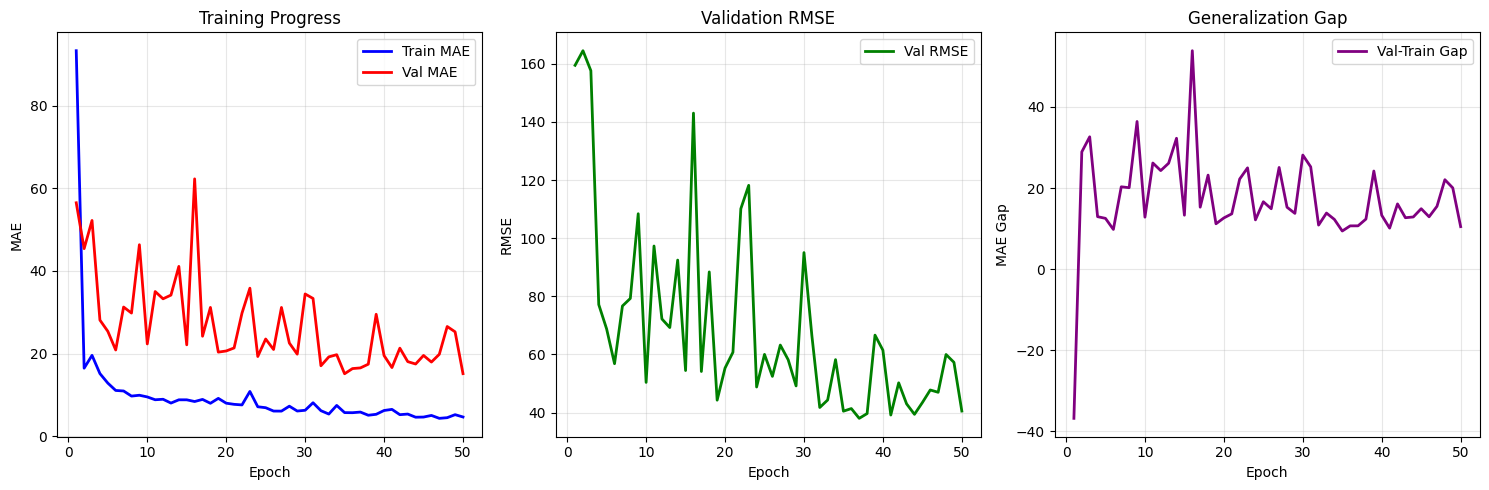

📈 Training Statistics:
   Final Train MAE: 4.659
   Final Val MAE: 15.143
   Final Val RMSE: 40.524
   Best Val MAE: 15.119
   Total Epochs: 50


In [26]:
# Plot training curves
if len(training_history['epoch']) > 0:
    plt.figure(figsize=(15, 5))

    # Training and validation MAE
    plt.subplot(1, 3, 1)
    plt.plot(training_history['epoch'], training_history['train_mae'], 'b-', label='Train MAE', linewidth=2)
    plt.plot(training_history['epoch'], training_history['val_mae'], 'r-', label='Val MAE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Validation RMSE
    plt.subplot(1, 3, 2)
    plt.plot(training_history['epoch'], training_history['val_rmse'], 'g-', label='Val RMSE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning curve analysis
    plt.subplot(1, 3, 3)
    train_mae = np.array(training_history['train_mae'])
    val_mae = np.array(training_history['val_mae'])
    gap = val_mae - train_mae
    plt.plot(training_history['epoch'], gap, 'purple', label='Val-Train Gap', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MAE Gap')
    plt.title('Generalization Gap')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("📈 Training Statistics:")
    print(f"   Final Train MAE: {training_history['train_mae'][-1]:.3f}")
    print(f"   Final Val MAE: {training_history['val_mae'][-1]:.3f}")
    print(f"   Final Val RMSE: {training_history['val_rmse'][-1]:.3f}")
    print(f"   Best Val MAE: {min(training_history['val_mae']):.3f}")
    print(f"   Total Epochs: {len(training_history['epoch'])}")
else:
    print("⚠️  No training history available. Please run the training loop first.")

📁 Loading best model checkpoint...
✅ Loaded model from epoch 35 with MAE 15.119

🎯 Final Evaluation - Ground Truth vs Predictions:
1722.jpg            : GT   10.0, Pred    6.3, Error   3.7
915.jpg             : GT  175.0, Pred  137.8, Error  37.2
6.jpg               : GT   10.0, Pred    7.2, Error   2.8
1406.jpg            : GT  658.0, Pred  654.1, Error   3.9
1293.jpg            : GT   29.0, Pred   34.0, Error   5.0
1464.jpg            : GT   53.0, Pred   48.4, Error   4.6
307.jpg             : GT   17.0, Pred   13.6, Error   3.4
1790.jpg            : GT   96.0, Pred   84.8, Error  11.2
418.jpg             : GT  351.0, Pred  279.7, Error  71.3
1720.jpg            : GT  196.0, Pred  192.4, Error   3.6
1891.jpg            : GT    3.0, Pred    2.0, Error   1.0
1249.jpg            : GT   24.0, Pred   19.9, Error   4.1
868.jpg             : GT   20.0, Pred   10.5, Error   9.5
903.jpg             : GT   13.0, Pred    7.4, Error   5.6
610.jpg             : GT    3.0, Pred    3.0, Error   0.0

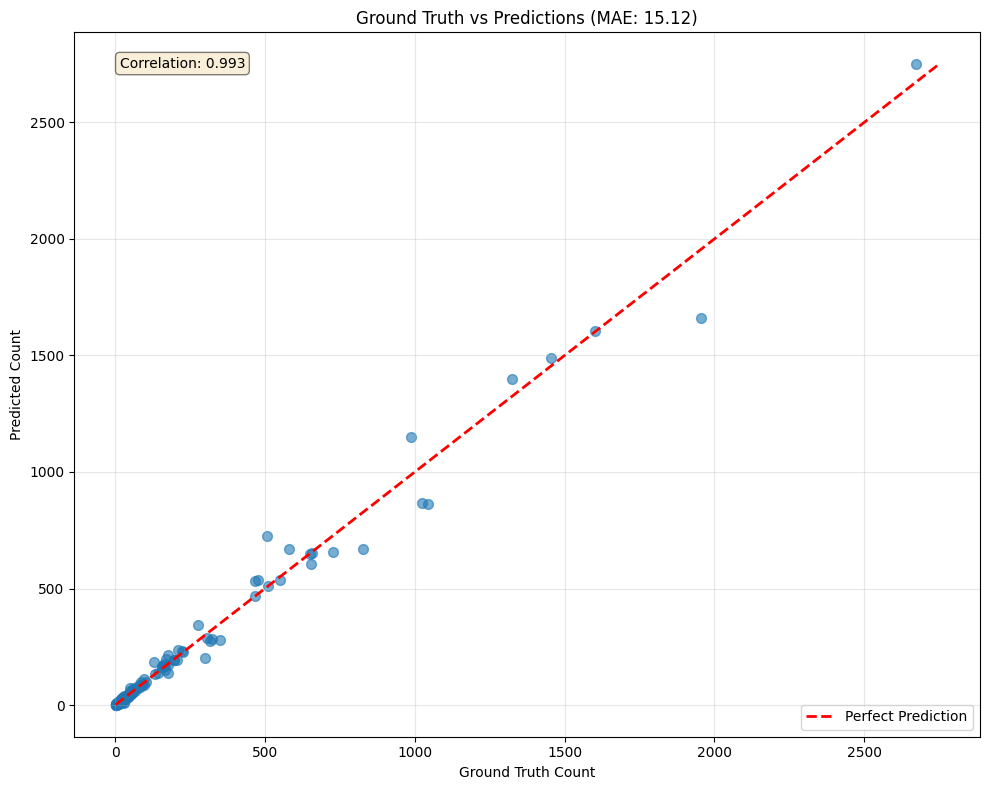


🔗 Correlation coefficient: 0.993


In [27]:
# Load best model for final evaluation
if os.path.exists(config['save_path']):
    print("📁 Loading best model checkpoint...")
    checkpoint = torch.load(config['save_path'], map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model"])
    print(f"✅ Loaded model from epoch {checkpoint['epoch']} with MAE {checkpoint['val_mae']:.3f}")

# Final evaluation with detailed predictions
print("\n🎯 Final Evaluation - Ground Truth vs Predictions:")
print("="*60)

model.eval()
predictions = []
ground_truths = []
image_names = []

with torch.no_grad():
    for batch_idx, (imgs, dens, _) in enumerate(val_loader):
        imgs = imgs.to(device)
        dens = dens.to(device)
        pred = model(imgs)

        pred_cnt_batch = pred.sum((1, 2, 3))
        gt_cnt_batch = dens.sum((1, 2, 3))

        # Store results
        for j in range(pred_cnt_batch.size(0)):
            idx = batch_idx * config['batch_size'] + j
            if idx < len(val_ds.img_paths):
                image_name = os.path.basename(val_ds.img_paths[idx])
                image_names.append(image_name)
                predictions.append(pred_cnt_batch[j].item())
                ground_truths.append(gt_cnt_batch[j].item())

                print(f"{image_name:20s}: GT {gt_cnt_batch[j].item():6.1f}, Pred {pred_cnt_batch[j].item():6.1f}, "
                      f"Error {abs(gt_cnt_batch[j].item() - pred_cnt_batch[j].item()):5.1f}")

# Calculate final metrics
if len(predictions) > 0:
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    mae = np.mean(np.abs(predictions - ground_truths))
    mse = np.mean((predictions - ground_truths)**2)
    rmse = np.sqrt(mse)

    print("\n📊 Final Metrics:")
    print(f"   MAE:  {mae:.3f}")
    print(f"   MSE:  {mse:.3f}")
    print(f"   RMSE: {rmse:.3f}")

    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(ground_truths, predictions, alpha=0.6, s=50)

    # Perfect prediction line
    max_val = max(np.max(ground_truths), np.max(predictions))
    min_val = min(np.min(ground_truths), np.min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.xlabel('Ground Truth Count')
    plt.ylabel('Predicted Count')
    plt.title(f'Ground Truth vs Predictions (MAE: {mae:.2f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add correlation coefficient
    correlation = np.corrcoef(ground_truths, predictions)[0, 1]
    plt.text(
        0.05,
        0.95,
        f'Correlation: {correlation:.3f}',
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5)
    )

    plt.tight_layout()
    plt.show()

    print(f"\n🔗 Correlation coefficient: {correlation:.3f}")
else:
    print("⚠️  No validation data processed.")

🎨 Visualizing sample predictions...


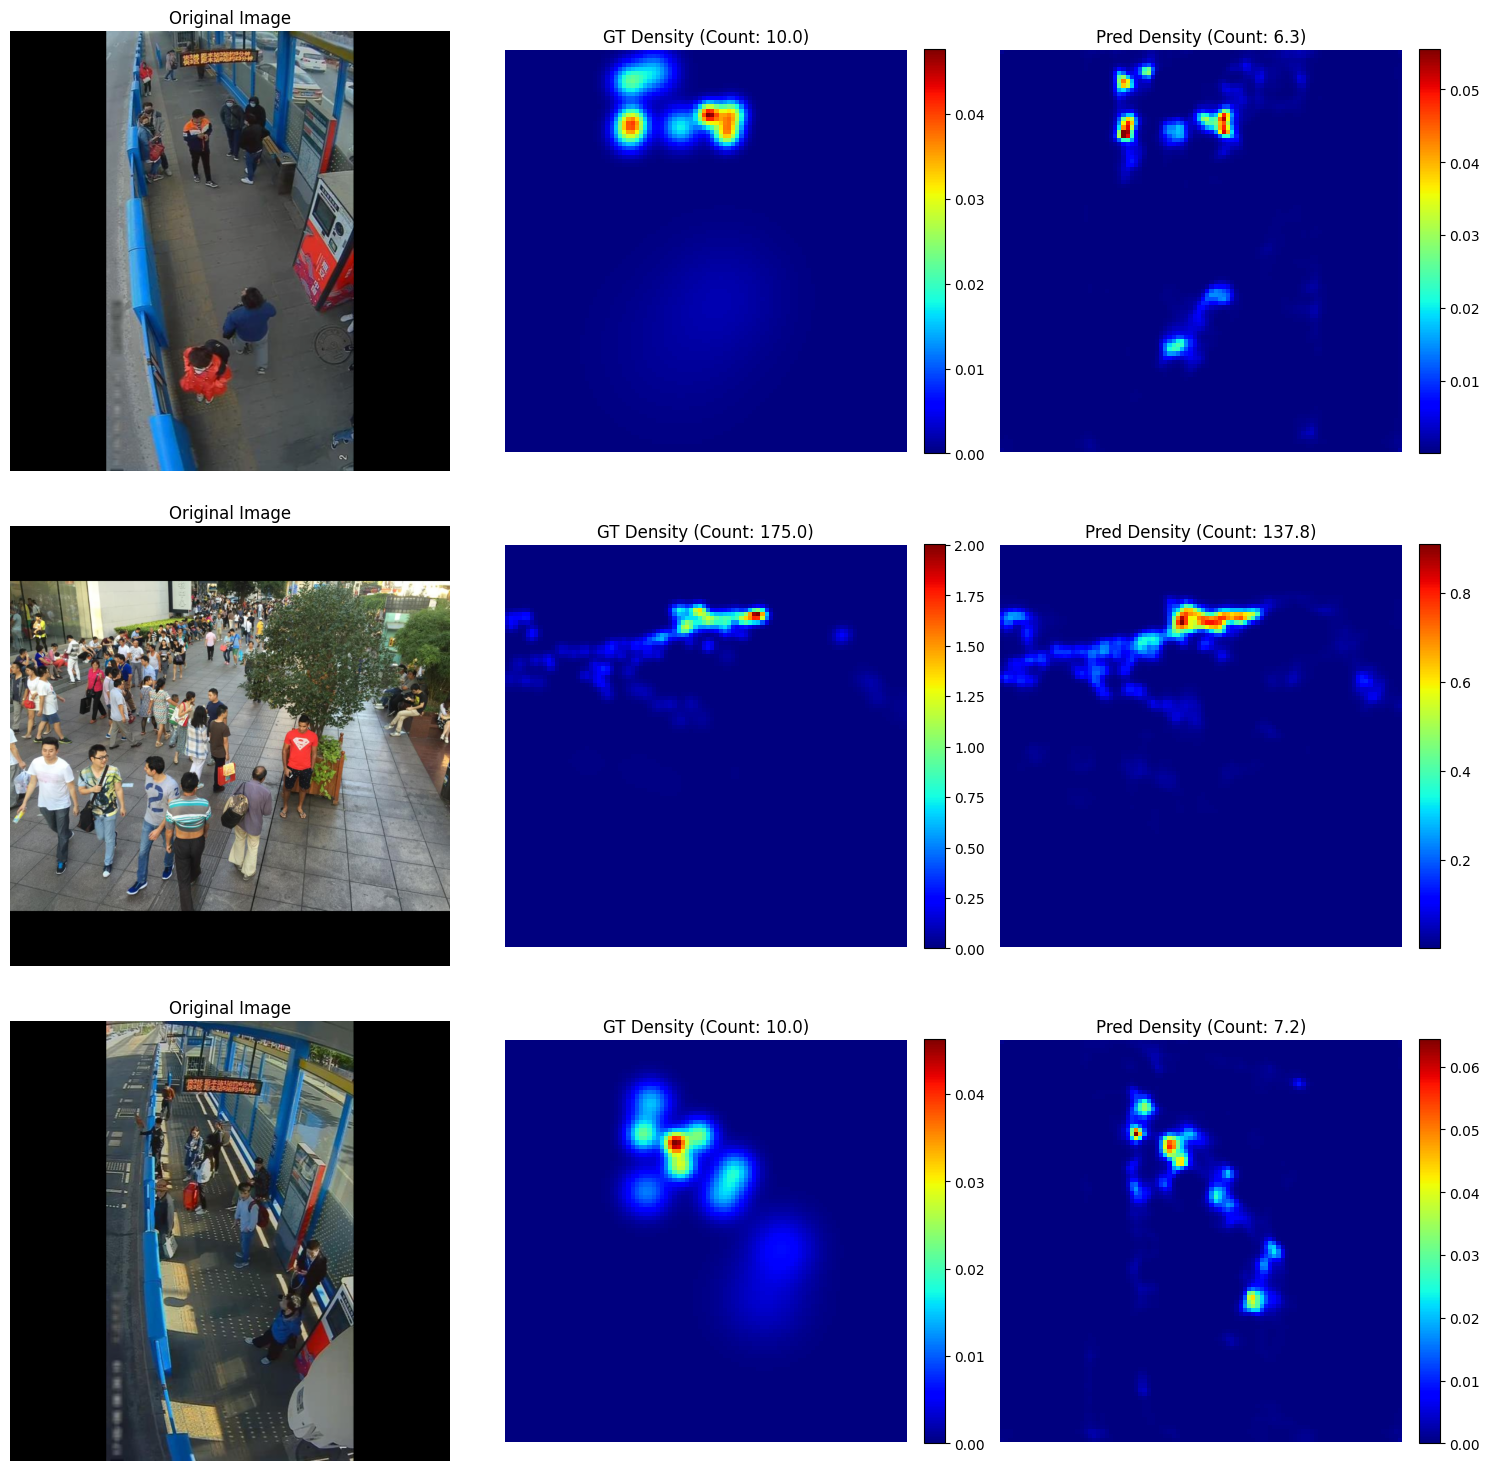


✅ Training and evaluation complete!
🎯 Final model saved at: sfcn_best.pth
📊 Training history and visualizations have been generated above.


In [28]:
# Visualize sample predictions with density maps
def visualize_predictions(
    model,
    dataset,
    device,
    num_samples=3
):
    """Visualize model predictions with density maps."""
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            if i >= len(dataset):
                break

            # Get sample
            img_tensor, gt_density, gt_count = dataset[i]
            img_tensor = img_tensor.unsqueeze(0).to(device)

            # Model prediction
            pred_density = model(img_tensor)

            # Convert to numpy
            img_np = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
            img_np = img_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)  # Denormalize
            img_np = np.clip(img_np, 0, 1)

            gt_density_np = gt_density.squeeze().numpy()
            pred_density_np = pred_density.squeeze().cpu().numpy()

            # Calculate counts
            gt_count_val = gt_density_np.sum()
            pred_count_val = pred_density_np.sum()

            # Plot original image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f'Original Image')
            axes[i, 0].axis('off')

            # Plot ground truth density
            im1 = axes[i, 1].imshow(gt_density_np, cmap='jet')
            axes[i, 1].set_title(f'GT Density (Count: {gt_count_val:.1f})')
            axes[i, 1].axis('off')
            plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)

            # Plot predicted density
            im2 = axes[i, 2].imshow(pred_density_np, cmap='jet')
            axes[i, 2].set_title(f'Pred Density (Count: {pred_count_val:.1f})')
            axes[i, 2].axis('off')
            plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Visualize predictions if validation dataset exists
try:
    print("🎨 Visualizing sample predictions...")
    visualize_predictions(model, val_ds, device, num_samples=3)
except NameError:
    print("⚠️  Validation dataset not available. Please run the data preparation cells first.")

print("\n✅ Training and evaluation complete!")
print(f"🎯 Final model saved at: {config['save_path']}")
print("📊 Training history and visualizations have been generated above.")

## Test Prediction and Generate Submission

Create predictions for test set and generate submission file.

In [29]:
# Create test dataset for inference
class TestDataset(Dataset):
    def __init__(self, img_dir: str, base_size: int = 768):
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.*")))
        self.base_size = base_size
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = imread_rgb(img_path)
        canvas, _, _, _ = letterbox(img, target=self.base_size)
        t = self.to_tensor(canvas)
        t = self.normalize(t)
        image_name = os.path.basename(img_path)
        return t, image_name

# Setup test dataset and loader
test_ds = TestDataset(config['test_dir'], base_size=config['base_size'])
test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

print(f"📦 Test dataset: {len(test_ds)} samples")
print(f"🚀 Test loader: {len(test_loader)} batches")

def generate_submission(model, test_loader, output_file="submission.csv"):
    model.eval()
    predictions, image_names = [], []

    with torch.no_grad():
        for images, names in test_loader:
            images = images.to(device)
            pred = model(images)
            batch_preds = pred.sum((1, 2, 3))

            # Round the result so predicted_count will store as int
            predictions.extend(batch_preds.cpu().numpy().round().astype(int).tolist())
            image_names.extend(names)

    submission_df = pd.DataFrame({
        "image_id": image_names,
        "predicted_count": predictions
    })

    # Sort by image ID (assuming numeric names)
    submission_df["sort_key"] = submission_df["image_id"].apply(lambda x: int(os.path.splitext(x)[0]))
    submission_df = submission_df.sort_values("sort_key").drop("sort_key", axis=1).reset_index(drop=True)

    submission_df.to_csv(output_file, index=False)
    print(f"✅ Submission saved to {output_file}")
    return submission_df

# Generate submission
submission_df = generate_submission(model, test_loader)
print("\n📋 Sample submission:")
print(submission_df.head(20))

📦 Test dataset: 500 samples
🚀 Test loader: 32 batches
✅ Submission saved to submission.csv

📋 Sample submission:
   image_id  predicted_count
0     1.jpg               11
1     2.jpg               30
2     3.jpg              201
3     4.jpg             1567
4     5.jpg              209
5     6.jpg              559
6     7.jpg               99
7     8.jpg              492
8     9.jpg                4
9    10.jpg               57
10   11.jpg              576
11   12.jpg              133
12   13.jpg               70
13   14.jpg               18
14   15.jpg                9
15   16.jpg                2
16   17.jpg                3
17   18.jpg               36
18   19.jpg                5
19   20.jpg               17
